# __mfusg_freyberg_example_____Beta__

In [1]:
from pathlib import Path
from pprint import pformat
# import git
import flopy
import os
import shutil
import Beta_dragon as hbd                                # ______________ new

In [2]:
org_d = os.path.join('freyberg_usg')
Beta_ws = os.path.join('v01_Beta')                       # ______________ New folder
if os.path.exists(Beta_ws):
    shutil.rmtree(Beta_ws)
shutil.copytree(org_d,Beta_ws)

'v01_Beta'

In [3]:
try:                                                                            
    root = Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
root_name = "freyberg.usg"      
data_path = "v01_Beta" if root else Path.cwd()
model_ws = data_path / root_name.replace(".", "_")

In [ ]:
from flopy.discretization import UnstructuredGrid                               # ____ Dependency
mfgrid = UnstructuredGrid.from_gridspec(str(model_ws / f"{root_name}.gsf"))

In [4]:
from flopy.utils.geometry import LineString
lines = [
    LineString(ls)
    for ls in [
        [(623000, 3364000), (623000, 3372000)],
        [(623650, 3364000), (623650, 3372000)],    ]]

In [5]:
gwf = flopy.mfusg.MfUsg.load(f"{root_name}.nam",    model_ws=str(model_ws),
    verbose=False,    check=False,    exe_name="mfusg",)                       # Loading the model
bas6 = gwf.get_package("bas6")
ibound = bas6.ibound.array

In [6]:
work_dir = os.path.join("v2_Beta_working_space")                               # work_dir

In [7]:
gwf.change_model_ws(str(work_dir))
gwf.write_name_file()
gwf.write_input()
success, buff = gwf.run_model(silent=True, report=True)
assert success, pformat(buff)


creating model workspace...
   v2_Beta_working_space


In [11]:
import numpy as np

hds = flopy.utils.HeadUFile(str("v2_Beta_working_space/freyberg.usg.hds"), model=gwf)
times = hds.get_times()
head = np.array(hds.get_data())
print(head.shape)

(3, 1499)


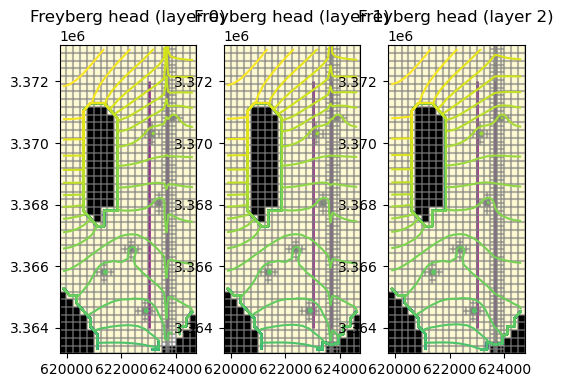

In [19]:
import matplotlib.pyplot as plt;

levels = np.arange(30, 35.4, 0.1)
fig = plt.figure(figsize=(6, 4))                                                    # 15, 10

for layer, h in enumerate(head):
    ax = fig.add_subplot(1, len(head), layer + 1)
    ax.set_title(f"Freyberg head (layer {layer})")
    pmv = flopy.plot.PlotMapView(modelgrid=mfgrid, ax=ax)
    mesh = pmv.plot_array(h, alpha=0.2)
    grid = pmv.plot_grid(alpha=0.2)
    shps = pmv.plot_shapes(lines, edgecolor="purple", lw=2, alpha=0.8)              # purple
    inac = pmv.plot_inactive(ibound=ibound)
    ctrs = pmv.contour_array(h, levels=levels)

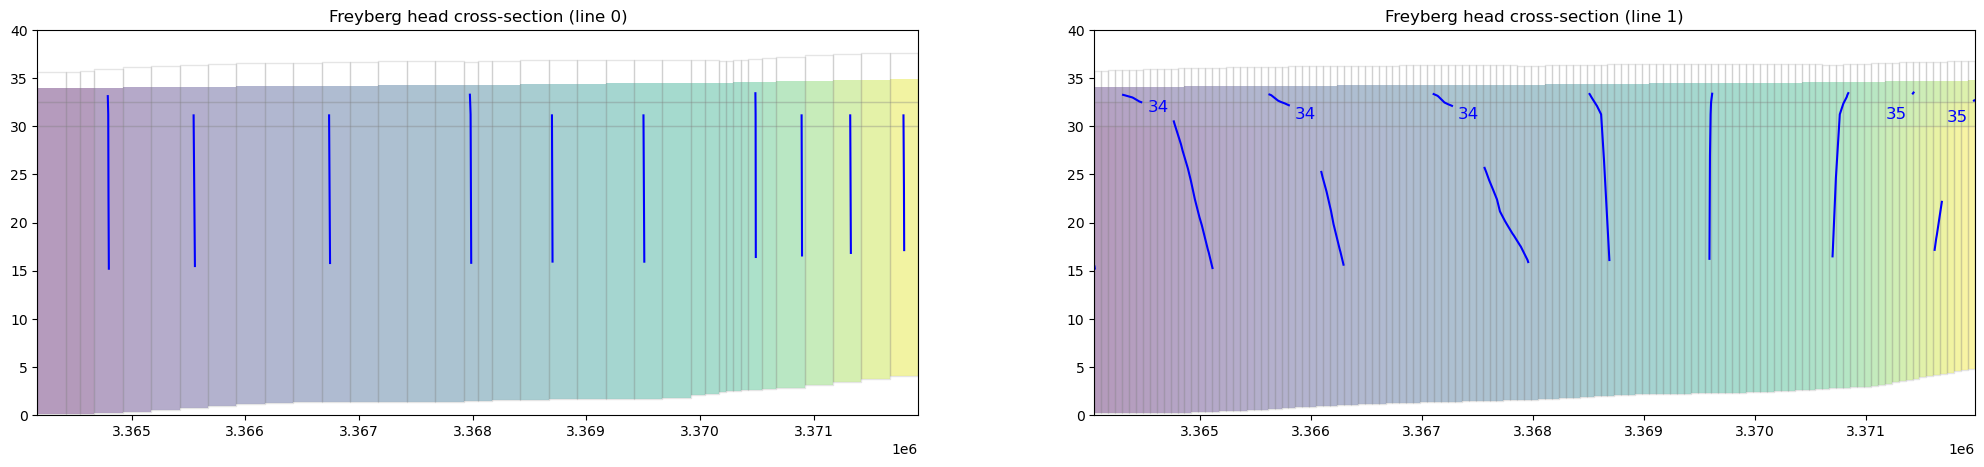

In [18]:
fig = plt.figure(figsize=(25, 5))

for i, line in enumerate(lines):
    ax = fig.add_subplot(1, len(lines), i + 1)
    ax.set_title(f"Freyberg head cross-section (line {i})")
    xsect = flopy.plot.PlotCrossSection(
        modelgrid=mfgrid, ax=ax, line={"line": lines[i]}, geographic_coords=True
    )
    xsect.plot_array(head, head=head, alpha=0.4)
    xsect.plot_ibound(ibound=ibound, head=head)
    xsect.plot_inactive(ibound=ibound)
    contours = xsect.contour_array(
        head, masked_values=[999.0], head=head, levels=levels, alpha=1.0, colors="blue"
    )
    plt.clabel(contours, fmt="%.0f", colors="blue", fontsize=12)
    xsect.plot_grid(alpha=0.2)
    ax.set_ylim([0, 40])  # set y axis range to ignore low elevations

In [ ]:

line = lines[0]

for time in times[0:3]:                             # _________________________________
    head = np.array(hds.get_data(totim=time))
    head2 = np.hstack(head)

    fig = plt.figure(figsize=(25, 5))
    
    ax = fig.add_subplot(1, 3, 1) # ______________________________________________________________________________________
    ax.set_title(f"Freyberg cross-section (t = {int(time)}, no head)")
    xsect = flopy.plot.PlotCrossSection(modelgrid=mfgrid, ax=ax, line={"line": line}, geographic_coords=True)
    cmap = xsect.plot_array(head2, masked_values=[-999.99], alpha=0.4)
    contours = xsect.contour_array(head2, levels=levels, alpha=1.0, colors="blue")
    xsect.plot_inactive(ibound=ibound, color_noflow=(0.8, 0.8, 0.8))
    xsect.plot_grid(alpha=0.2)
    ax.set_ylim([0, 40])  # set y axis range to ignore low elevations

